In [1]:
from ioh import get_problem, ProblemClass
from ioh import logger
import math
import os
from dataclasses import dataclass
import BA 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.random_projection import GaussianRandomProjection
import botorch
import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from sklearn.preprocessing import StandardScaler


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")

# problem dimension
dim = 40 if not SMOKE_TEST else 50
projected_dim = 15

# initial sample points
n_init = 10 if not SMOKE_TEST else 4
max_cholesky_size = float("inf")

problem = get_problem(1, dimension=dim, instance=2, problem_class=ProblemClass.BBOB)

Running on cpu


In [3]:
EVALUATION_BUDGET = 100 if not SMOKE_TEST else 10
NUM_RESTARTS = 3 if not SMOKE_TEST else 2
RAW_SAMPLES = 51 if not SMOKE_TEST else 4
N_CANDIDATES = min(dim, max(200, 20 * dim)) if not SMOKE_TEST else 4

# BAxUS

In [4]:
state = BA.BaxusState(dim=dim, eval_budget=EVALUATION_BUDGET - n_init)
Y_baxus_all = []
embedding_functions = [BA.embedding_matrix, BA.embedding_matrix_random, 
                       BA.embedding_matrix_morenonzero, BA.multi_scale_embedding]
for idx, embedding_func in enumerate(embedding_functions):
    S = embedding_func(input_dim=state.dim, target_dim=state.d_init)
    print(S.shape)
    X_baxus_target = BA.get_initial_points(state.d_init, n_init)
    X_baxus_input = X_baxus_target @ S

    Y_baxus = torch.tensor(
        [-problem(list(x)) for x in X_baxus_input], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Disable input scaling checks as we normalize to [-1, 1]
    with botorch.settings.validate_input_scaling(False):
        for _ in range(EVALUATION_BUDGET - n_init):  # Run until evaluation budget depleted
            # Fit a GP model
            train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
            likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
            model = SingleTaskGP(
                X_baxus_target, train_Y, likelihood=likelihood
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)

            # Do the fitting and acquisition function optimization inside the Cholesky context
            with gpytorch.settings.max_cholesky_size(max_cholesky_size):
                # Fit the model
                try:
                    fit_gpytorch_mll(mll)
                except ModelFittingError:
                    # Right after increasing the target dimensionality, the covariance matrix becomes indefinite
                    # In this case, the Cholesky decomposition might fail due to numerical instabilities
                    # In this case, we revert to Adam-based optimization
                    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)
                    for _ in range(200):
                        optimizer.zero_grad()
                        output = model(X_baxus_target)
                        loss = -mll(output, train_Y.flatten())
                        loss.backward()
                        optimizer.step()
                X_next_target = BA.create_candidate(
                    state=state,
                    model=model,
                    X=X_baxus_target,
                    Y=train_Y,
                    device=device,
                    dtype=dtype,
                    n_candidates=N_CANDIDATES,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                    acqf="ts",
                )
            X_next_input = X_next_target @ S
            Y_next = torch.tensor(
                [-problem(list(x)) for x in X_next_input], dtype=dtype, device=device
            ).unsqueeze(-1)

            state = BA.update_state(state=state, Y_next=Y_next)

            X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
            X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
            Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)

            print(
                f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
            )

            if state.restart_triggered:
                state.restart_triggered = False
                print("increasing target space")

                S, X_baxus_target = BA.increase_embedding_and_observations(
                    S, X_baxus_target, state.new_bins_on_split
                )
                print(f"new dimensionality: {len(S)}")
                
                state.target_dim = len(S)
                state.length = state.length_init
                state.failure_counter = 0
                state.success_counter = 0
    Y_baxus_all.append(Y_baxus)

torch.Size([1, 40])


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 11, d=1)  Best value: -6.77e+02, TR length: 0.4
iteration 12, d=1)  Best value: -6.77e+02, TR length: 0.2
iteration 13, d=1)  Best value: -6.77e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 14, d=1)  Best value: -6.77e+02, TR length: 0.05
iteration 15, d=1)  Best value: -6.77e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 16, d=1)  Best value: -6.77e+02, TR length: 0.0125
iteration 17, d=1)  Best value: -6.77e+02, TR length: 0.00625
increasing target space
new dimensionality: 3
iteration 18, d=3)  Best value: -6.77e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 19, d=3)  Best value: -6.77e+02, TR length: 0.2
iteration 20, d=3)  Best value: -6.73e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 21, d=3)  Best value: -6.72e+02, TR length: 0.2
iteration 22, d=3)  Best value: -6.72e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 23, d=3)  Best value: -6.72e+02, TR length: 0.05
iteration 24, d=3)  Best value: -6.72e+02, TR length: 0.025
iteration 25, d=3)  Best value: -6.71e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 26, d=3)  Best value: -6.71e+02, TR length: 0.00625
increasing target space
new dimensionality: 9
iteration 27, d=9)  Best value: -6.71e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 28, d=9)  Best value: -6.71e+02, TR length: 0.2
iteration 29, d=9)  Best value: -6.7e+02, TR length: 0.2
iteration 30, d=9)  Best value: -6.7e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 31, d=9)  Best value: -6.69e+02, TR length: 0.1
iteration 32, d=9)  Best value: -6.68e+02, TR length: 0.1
iteration 33, d=9)  Best value: -6.68e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 34, d=9)  Best value: -6.68e+02, TR length: 0.025
iteration 35, d=9)  Best value: -6.67e+02, TR length: 0.0125
iteration 36, d=9)  Best value: -6.67e+02, TR length: 0.00625
increasing target space
new dimensionality: 27


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 37, d=27)  Best value: -6.67e+02, TR length: 0.8
iteration 38, d=27)  Best value: -6.67e+02, TR length: 0.8
iteration 39, d=27)  Best value: -6.49e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 40, d=27)  Best value: -6.49e+02, TR length: 0.8
iteration 41, d=27)  Best value: -6.49e+02, TR length: 0.8
iteration 42, d=27)  Best value: -6.49e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 43, d=27)  Best value: -6.37e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 44, d=27)  Best value: -6.37e+02, TR length: 0.8
iteration 45, d=27)  Best value: -6.37e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 46, d=27)  Best value: -6.37e+02, TR length: 0.8
iteration 47, d=27)  Best value: -6.37e+02, TR length: 0.4
iteration 48, d=27)  Best value: -6.37e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 49, d=27)  Best value: -6.37e+02, TR length: 0.4
iteration 50, d=27)  Best value: -6.31e+02, TR length: 0.4
iteration 51, d=27)  Best value: -6.31e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 52, d=27)  Best value: -6.24e+02, TR length: 0.4
iteration 53, d=27)  Best value: -6.19e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 54, d=27)  Best value: -6.19e+02, TR length: 0.4
iteration 55, d=27)  Best value: -6.19e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 56, d=27)  Best value: -6.19e+02, TR length: 0.4
iteration 57, d=27)  Best value: -6.19e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 58, d=27)  Best value: -6.19e+02, TR length: 0.2
iteration 59, d=27)  Best value: -6.19e+02, TR length: 0.2
iteration 60, d=27)  Best value: -6.17e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 61, d=27)  Best value: -6.16e+02, TR length: 0.2
iteration 62, d=27)  Best value: -6.15e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 63, d=27)  Best value: -6.15e+02, TR length: 0.4
iteration 64, d=27)  Best value: -6.15e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 65, d=27)  Best value: -6.15e+02, TR length: 0.4
iteration 66, d=27)  Best value: -6.15e+02, TR length: 0.2
iteration 67, d=27)  Best value: -6.14e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 68, d=27)  Best value: -6.13e+02, TR length: 0.2
iteration 69, d=27)  Best value: -6.13e+02, TR length: 0.2
iteration 70, d=27)  Best value: -6.13e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 71, d=27)  Best value: -6.12e+02, TR length: 0.2
iteration 72, d=27)  Best value: -6.09e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  war

iteration 73, d=27)  Best value: -6.08e+02, TR length: 0.2
iteration 74, d=27)  Best value: -6.07e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 75, d=27)  Best value: -6.07e+02, TR length: 0.4
iteration 76, d=27)  Best value: -6.07e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 77, d=27)  Best value: -6.07e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 78, d=27)  Best value: -6.07e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 79, d=27)  Best value: -6.07e+02, TR length: 0.2
iteration 80, d=27)  Best value: -6.05e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 81, d=27)  Best value: -6.05e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 82, d=27)  Best value: -6.05e+02, TR length: 0.2
iteration 83, d=27)  Best value: -6.04e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 84, d=27)  Best value: -6.04e+02, TR length: 0.2
iteration 85, d=27)  Best value: -6.04e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 86, d=27)  Best value: -6.04e+02, TR length: 0.2
iteration 87, d=27)  Best value: -6.02e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 88, d=27)  Best value: -6.02e+02, TR length: 0.2
iteration 89, d=27)  Best value: -6.02e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 90, d=27)  Best value: -6.02e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 91, d=27)  Best value: -6.02e+02, TR length: 0.1
iteration 92, d=27)  Best value: -6.02e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskG

iteration 93, d=27)  Best value: -6.02e+02, TR length: 0.1
iteration 94, d=27)  Best value: -6.02e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 95, d=27)  Best value: -6.02e+02, TR length: 0.05
iteration 96, d=27)  Best value: -6.02e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 97, d=27)  Best value: -6.01e+02, TR length: 0.05
iteration 98, d=27)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 99, d=27)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 100, d=27)  Best value: -6.01e+02, TR length: 0.025
torch.Size([1, 40])
iteration 11, d=1)  Best value: -6.01e+02, TR length: 0.025
iteration 12, d=1)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 13, d=1)  Best value: -6.01e+02, TR length: 0.0125
iteration 14, d=1)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 15, d=1)  Best value: -6.01e+02, TR length: 0.0125
iteration 16, d=1)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 17, d=1)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 3
iteration 18, d=3)  Best value: -6.01e+02, TR length: 0.4
iteration 19, d=3)  Best value: -6.01e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 20, d=3)  Best value: -6.01e+02, TR length: 0.1
iteration 21, d=3)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 22, d=3)  Best value: -6.01e+02, TR length: 0.025
iteration 23, d=3)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 24, d=3)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 9


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 25, d=9)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 26, d=9)  Best value: -6.01e+02, TR length: 0.2
iteration 27, d=9)  Best value: -6.01e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 28, d=9)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 29, d=9)  Best value: -6.01e+02, TR length: 0.025
iteration 30, d=9)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 31, d=9)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 27


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_L

iteration 32, d=27)  Best value: -6.01e+02, TR length: 0.8
iteration 33, d=27)  Best value: -6.01e+02, TR length: 0.8
iteration 34, d=27)  Best value: -6.01e+02, TR length: 0.8


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 35, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 36, d=27)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 37, d=27)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 38, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 39, d=27)  Best value: -6.01e+02, TR length: 0.2
iteration 40, d=27)  Best value: -6.01e+02, TR length: 0.2
iteration 41, d=27)  Best value: -6.01e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 42, d=27)  Best value: -6.01e+02, TR length: 0.2
iteration 43, d=27)  Best value: -6.01e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 44, d=27)  Best value: -6.01e+02, TR length: 0.1
iteration 45, d=27)  Best value: -6.01e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 46, d=27)  Best value: -6.01e+02, TR length: 0.1
iteration 47, d=27)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 48, d=27)  Best value: -6.01e+02, TR length: 0.05
iteration 49, d=27)  Best value: -6.01e+02, TR length: 0.05
iteration 50, d=27)  Best value: -6.01e+02, TR length: 0.05


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 51, d=27)  Best value: -6.01e+02, TR length: 0.025
iteration 52, d=27)  Best value: -6.01e+02, TR length: 0.025


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_

iteration 53, d=27)  Best value: -6.01e+02, TR length: 0.025
iteration 54, d=27)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 55, d=27)  Best value: -6.01e+02, TR length: 0.0125
iteration 56, d=27)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 57, d=27)  Best value: -6.01e+02, TR length: 0.0125
iteration 58, d=27)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 59, d=27)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 39
iteration 60, d=39)  Best value: -6.01e+02, TR length: 0.8
iteration 61, d=39)  Best value: -6.01e+02, TR length: 0.8
iteration 62, d=39)  Best value: -6.01e+02, TR length: 0.8


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 63, d=39)  Best value: -6.01e+02, TR length: 0.8


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 64, d=39)  Best value: -6.01e+02, TR length: 0.8


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 65, d=39)  Best value: -6.01e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 66, d=39)  Best value: -6.01e+02, TR length: 0.4
iteration 67, d=39)  Best value: -6.01e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 68, d=39)  Best value: -6.01e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 69, d=39)  Best value: -6.01e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.war

iteration 70, d=39)  Best value: -6.01e+02, TR length: 0.4
iteration 71, d=39)  Best value: -6.01e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 72, d=39)  Best value: -6.01e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 73, d=39)  Best value: -6.01e+02, TR length: 0.2
iteration 74, d=39)  Best value: -6.01e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 75, d=39)  Best value: -6.01e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 76, d=39)  Best value: -6.01e+02, TR length: 0.2
iteration 77, d=39)  Best value: -6.01e+02, TR length: 0.1


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 78, d=39)  Best value: -6.01e+02, TR length: 0.1


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 79, d=39)  Best value: -6.01e+02, TR length: 0.1


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 80, d=39)  Best value: -6.01e+02, TR length: 0.1


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.war

iteration 81, d=39)  Best value: -6.01e+02, TR length: 0.1
iteration 82, d=39)  Best value: -6.01e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 83, d=39)  Best value: -6.01e+02, TR length: 0.05
iteration 84, d=39)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 85, d=39)  Best value: -6.01e+02, TR length: 0.05
iteration 86, d=39)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  w

iteration 87, d=39)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.war

iteration 88, d=39)  Best value: -6.01e+02, TR length: 0.05
iteration 89, d=39)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 90, d=39)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 91, d=39)  Best value: -6.01e+02, TR length: 0.025
iteration 92, d=39)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 93, d=39)  Best value: -6.01e+02, TR length: 0.025
iteration 94, d=39)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 95, d=39)  Best value: -6.01e+02, TR length: 0.0125
iteration 96, d=39)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 97, d=39)  Best value: -6.01e+02, TR length: 0.0125
iteration 98, d=39)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 99, d=39)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.war

iteration 100, d=39)  Best value: -6.01e+02, TR length: 0.0125
torch.Size([1, 40])
iteration 11, d=1)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 3
iteration 12, d=3)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 13, d=3)  Best value: -6.01e+02, TR length: 0.2
iteration 14, d=3)  Best value: -6.01e+02, TR length: 0.1
iteration 15, d=3)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 16, d=3)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 17, d=3)  Best value: -6.01e+02, TR length: 0.0125
iteration 18, d=3)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 9


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 19, d=9)  Best value: -6.01e+02, TR length: 0.4
iteration 20, d=9)  Best value: -6.01e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 21, d=9)  Best value: -6.01e+02, TR length: 0.1
iteration 22, d=9)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 23, d=9)  Best value: -6.01e+02, TR length: 0.025
iteration 24, d=9)  Best value: -6.01e+02, TR length: 0.0125
iteration 25, d=9)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 27


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 26, d=27)  Best value: -6.01e+02, TR length: 0.8
iteration 27, d=27)  Best value: -6.01e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 28, d=27)  Best value: -6.01e+02, TR length: 0.8
iteration 29, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 30, d=27)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 31, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 32, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 33, d=27)  Best value: -6.01e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 34, d=27)  Best value: -6.01e+02, TR length: 0.2
iteration 35, d=27)  Best value: -6.01e+02, TR length: 0.2
iteration 36, d=27)  Best value: -6.01e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 37, d=27)  Best value: -6.01e+02, TR length: 0.1
iteration 38, d=27)  Best value: -6.01e+02, TR length: 0.1
iteration 39, d=27)  Best value: -6.01e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 40, d=27)  Best value: -6.01e+02, TR length: 0.1
iteration 41, d=27)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 42, d=27)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 43, d=27)  Best value: -6.01e+02, TR length: 0.05
iteration 44, d=27)  Best value: -6.01e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 45, d=27)  Best value: -6.01e+02, TR length: 0.025
iteration 46, d=27)  Best value: -6.01e+02, TR length: 0.025
iteration 47, d=27)  Best value: -6.01e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 48, d=27)  Best value: -6.01e+02, TR length: 0.025
iteration 49, d=27)  Best value: -6.01e+02, TR length: 0.0125
iteration 50, d=27)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 51, d=27)  Best value: -6.01e+02, TR length: 0.0125
iteration 52, d=27)  Best value: -6.01e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 53, d=27)  Best value: -6.01e+02, TR length: 0.00625
increasing target space
new dimensionality: 40
iteration 54, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 55, d=40)  Best value: -6.01e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 56, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 57, d=40)  Best value: -6.01e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskG

iteration 58, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 59, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 60, d=40)  Best value: -6.01e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 61, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 62, d=40)  Best value: -6.01e+02, TR length: 0.8
iteration 63, d=40)  Best value: -5.95e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 64, d=40)  Best value: -5.95e+02, TR length: 0.8
iteration 65, d=40)  Best value: -5.95e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 66, d=40)  Best value: -5.9e+02, TR length: 0.8
iteration 67, d=40)  Best value: -5.88e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 68, d=40)  Best value: -5.88e+02, TR length: 0.8
iteration 69, d=40)  Best value: -5.88e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 70, d=40)  Best value: -5.88e+02, TR length: 0.8
iteration 71, d=40)  Best value: -5.88e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 72, d=40)  Best value: -5.83e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 73, d=40)  Best value: -5.83e+02, TR length: 0.8
iteration 74, d=40)  Best value: -5.8e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 75, d=40)  Best value: -5.8e+02, TR length: 0.8
iteration 76, d=40)  Best value: -5.8e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 77, d=40)  Best value: -5.76e+02, TR length: 0.8
iteration 78, d=40)  Best value: -5.76e+02, TR length: 0.8
iteration 79, d=40)  Best value: -5.76e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 80, d=40)  Best value: -5.76e+02, TR length: 0.8
iteration 81, d=40)  Best value: -5.76e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 82, d=40)  Best value: -5.76e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 83, d=40)  Best value: -5.76e+02, TR length: 0.8
iteration 84, d=40)  Best value: -5.76e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 85, d=40)  Best value: -5.76e+02, TR length: 0.8


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 86, d=40)  Best value: -5.76e+02, TR length: 0.8
iteration 87, d=40)  Best value: -5.76e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 88, d=40)  Best value: -5.71e+02, TR length: 0.8
iteration 89, d=40)  Best value: -5.71e+02, TR length: 0.8
iteration 90, d=40)  Best value: -5.71e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 91, d=40)  Best value: -5.71e+02, TR length: 0.8
iteration 92, d=40)  Best value: -5.71e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 93, d=40)  Best value: -5.71e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 94, d=40)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskG

iteration 95, d=40)  Best value: -5.69e+02, TR length: 0.8
iteration 96, d=40)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 97, d=40)  Best value: -5.69e+02, TR length: 0.8
iteration 98, d=40)  Best value: -5.69e+02, TR length: 0.8
iteration 99, d=40)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  w

iteration 100, d=40)  Best value: -5.69e+02, TR length: 0.8
torch.Size([1, 40])
iteration 11, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 12, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 13, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 14, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 15, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 16, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 17, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 18, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 19, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 20, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 21, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 22, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 23, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 24, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 25, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 26, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 27, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 28, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 29, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 30, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 31, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 32, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 33, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 34, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 35, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 36, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 37, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 38, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 39, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 40, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 41, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 42, d=1)  Best value: -5.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 43, d=1)  Best value: -5.69e+02, TR length: 0.8
iteration 44, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use

iteration 45, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 46, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 47, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 48, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 49, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 50, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 51, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 52, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 53, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 54, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 55, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 56, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 57, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 58, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 59, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 60, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 61, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 62, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 63, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 64, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 65, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 66, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 67, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 68, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 69, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 70, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 71, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 72, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 73, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 74, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 75, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 76, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 77, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 78, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 79, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 80, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: Numerical

iteration 81, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 82, d=1)  Best value: -5.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original m

iteration 83, d=1)  Best value: -5.69e+02, TR length: 0.4
iteration 84, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 85, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 86, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 87, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 88, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 89, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  w

iteration 90, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 91, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 92, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 93, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 94, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 95, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 96, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 97, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 98, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 99, d=1)  Best value: -5.69e+02, TR length: 0.2
iteration 100, d=1)  Best value: -5.69e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/3631527161.py:21: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

# TURBO

In [5]:
'''batch_size = 4
state = BA.TurboState(dim, batch_size=batch_size)

X_turbo = BA.get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [-problem(list(x)) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)
evaluation_budget = EVALUATION_BUDGET - n_init  # Remaining evaluations after initialization

while not state.restart_triggered and evaluation_budget > 0:  # Run until TuRBO converges or budget exhausted
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    batch_size = min(batch_size, evaluation_budget)  # Ensure batch size doesn't exceed remaining budget

    # Create a batch
    X_next = BA.create_candidate_turbo(
        state=state,
        model=model,
        X=X_turbo,
        Y=train_Y,
        batch_size=batch_size,
        n_candidates=min(5000, max(2000, 200 * dim)),
        num_restarts=10,
        raw_samples=512,
        acqf="ts",
    )
    Y_next = torch.tensor(
        [-problem(list(x)) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = BA.update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)
    evaluation_budget -= batch_size

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )'''

'batch_size = 4\nstate = BA.TurboState(dim, batch_size=batch_size)\n\nX_turbo = BA.get_initial_points(dim, n_init)\nY_turbo = torch.tensor(\n    [-problem(list(x)) for x in X_turbo], dtype=dtype, device=device\n).unsqueeze(-1)\nevaluation_budget = EVALUATION_BUDGET - n_init  # Remaining evaluations after initialization\n\nwhile not state.restart_triggered and evaluation_budget > 0:  # Run until TuRBO converges or budget exhausted\n    # Fit a GP model\n    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()\n    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))\n    model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)\n    mll = ExactMarginalLogLikelihood(model.likelihood, model)\n    fit_gpytorch_mll(mll)\n    batch_size = min(batch_size, evaluation_budget)  # Ensure batch size doesn\'t exceed remaining budget\n\n    # Create a batch\n    X_next = BA.create_candidate_turbo(\n        state=state,\n        model=model,\n        X=X_turbo,\n        Y=train_

In [6]:
state = BA.BaxusState(dim=dim, eval_budget=EVALUATION_BUDGET - n_init)
n_sample = 40
X_sample = BA.get_initial_points(state.d_init, n_sample)
S = BA.embedding_matrix_pca(input_dim=state.dim, target_dim=state.d_init, data=X_sample)
print(state.dim,  state.d_init)
print(S.shape)

X_baxus_target = BA.get_initial_points(state.d_init, n_init)
print(X_baxus_target.shape)

X_baxus_input = X_baxus_target @ S
print(X_baxus_input.shape)

Y_baxus = torch.tensor(
        [-problem(list(x)) for x in X_baxus_input], dtype=dtype, device=device
    ).unsqueeze(-1)
print(Y_baxus.shape)
with botorch.settings.validate_input_scaling(False):
    for _ in range(EVALUATION_BUDGET - n_init):  # Run until evaluation budget depleted
            # Fit a GP model
            train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
            likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
            model = SingleTaskGP(
                X_baxus_target, train_Y, likelihood=likelihood
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)

            # Fit the model using Cholesky context
            with gpytorch.settings.max_cholesky_size(max_cholesky_size):
                try:
                    fit_gpytorch_mll(mll)
                except ModelFittingError:
                    # Use Adam-based optimization if Cholesky decomposition fails
                    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)
                    for _ in range(200):
                        optimizer.zero_grad()
                        output = model(X_baxus_target)
                        loss = -mll(output, train_Y.flatten())
                        loss.backward()
                        optimizer.step()

                # Generate new candidates
                X_next_target = BA.create_candidate(
                    state=state,
                    model=model,
                    X=X_baxus_target,
                    Y=train_Y,
                    device=device,
                    dtype=dtype,
                    n_candidates=N_CANDIDATES,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                    acqf="ts",
                )
            
            # Map new candidates to high-dimensional space
            X_next_input = X_next_target @ S
            Y_next = torch.tensor(
                [-problem(list(x)) for x in X_next_input], dtype=dtype, device=device
            ).unsqueeze(-1)

            # Update state and concatenate new points
            state = BA.update_state(state=state, Y_next=Y_next)
            X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
            X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
            Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)
            
            print(
                f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
            )

            if state.restart_triggered:
                state.restart_triggered = False
                print("increasing target space")

                S, X_baxus_target = BA.increase_embedding_and_observations(
                    S, X_baxus_target, state.new_bins_on_split
                )
                print(f"new dimensionality: {len(S)}")
                
                state.target_dim = len(S)
                state.length = state.length_init
                state.failure_counter = 0
                state.success_counter = 0
    Y_baxus_all.append(Y_baxus)

/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


40 1
torch.Size([1, 40])
torch.Size([10, 1])
torch.Size([10, 40])
torch.Size([10, 1])
iteration 11, d=1)  Best value: -6.75e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 12, d=1)  Best value: -6.75e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 13, d=1)  Best value: -6.75e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 14, d=1)  Best value: -6.75e+02, TR length: 0.05
iteration 15, d=1)  Best value: -6.75e+02, TR length: 0.025
iteration 16, d=1)  Best value: -6.75e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 17, d=1)  Best value: -6.75e+02, TR length: 0.00625
increasing target space
new dimensionality: 3
iteration 18, d=3)  Best value: -6.75e+02, TR length: 0.4
iteration 19, d=3)  Best value: -6.75e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 20, d=3)  Best value: -6.74e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 21, d=3)  Best value: -6.74e+02, TR length: 0.05
iteration 22, d=3)  Best value: -6.74e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 23, d=3)  Best value: -6.74e+02, TR length: 0.0125
iteration 24, d=3)  Best value: -6.74e+02, TR length: 0.00625
increasing target space
new dimensionality: 9


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 25, d=9)  Best value: -6.74e+02, TR length: 0.4
iteration 26, d=9)  Best value: -6.74e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_L

iteration 27, d=9)  Best value: -6.74e+02, TR length: 0.1
iteration 28, d=9)  Best value: -6.74e+02, TR length: 0.05
iteration 29, d=9)  Best value: -6.73e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 30, d=9)  Best value: -6.73e+02, TR length: 0.0125
iteration 31, d=9)  Best value: -6.73e+02, TR length: 0.00625
increasing target space
new dimensionality: 27


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 32, d=27)  Best value: -6.72e+02, TR length: 0.8
iteration 33, d=27)  Best value: -6.72e+02, TR length: 0.8
iteration 34, d=27)  Best value: -6.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 35, d=27)  Best value: -6.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_L

iteration 36, d=27)  Best value: -6.69e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 37, d=27)  Best value: -6.69e+02, TR length: 0.8
iteration 38, d=27)  Best value: -6.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 39, d=27)  Best value: -6.69e+02, TR length: 0.4
iteration 40, d=27)  Best value: -6.69e+02, TR length: 0.4
iteration 41, d=27)  Best value: -6.69e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 42, d=27)  Best value: -6.68e+02, TR length: 0.4
iteration 43, d=27)  Best value: -6.68e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 44, d=27)  Best value: -6.67e+02, TR length: 0.4
iteration 45, d=27)  Best value: -6.67e+02, TR length: 0.4
iteration 46, d=27)  Best value: -6.67e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 47, d=27)  Best value: -6.66e+02, TR length: 0.4
iteration 48, d=27)  Best value: -6.66e+02, TR length: 0.2
iteration 49, d=27)  Best value: -6.66e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 50, d=27)  Best value: -6.66e+02, TR length: 0.2
iteration 51, d=27)  Best value: -6.65e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 52, d=27)  Best value: -6.65e+02, TR length: 0.1
iteration 53, d=27)  Best value: -6.65e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 54, d=27)  Best value: -6.65e+02, TR length: 0.1
iteration 55, d=27)  Best value: -6.65e+02, TR length: 0.1
iteration 56, d=27)  Best value: -6.64e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 57, d=27)  Best value: -6.64e+02, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 58, d=27)  Best value: -6.64e+02, TR length: 0.05
iteration 59, d=27)  Best value: -6.64e+02, TR length: 0.05
iteration 60, d=27)  Best value: -6.64e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 61, d=27)  Best value: -6.64e+02, TR length: 0.025
iteration 62, d=27)  Best value: -6.64e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 63, d=27)  Best value: -6.64e+02, TR length: 0.025
iteration 64, d=27)  Best value: -6.64e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 65, d=27)  Best value: -6.64e+02, TR length: 0.0125
iteration 66, d=27)  Best value: -6.64e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 67, d=27)  Best value: -6.64e+02, TR length: 0.0125
iteration 68, d=27)  Best value: -6.64e+02, TR length: 0.00625
increasing target space
new dimensionality: 40
iteration 69, d=40)  Best value: -6.64e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 70, d=40)  Best value: -6.64e+02, TR length: 0.8
iteration 71, d=40)  Best value: -6.64e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 72, d=40)  Best value: -6.64e+02, TR length: 0.8
iteration 73, d=40)  Best value: -6.64e+02, TR length: 0.8
iteration 74, d=40)  Best value: -6.64e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 75, d=40)  Best value: -6.64e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 76, d=40)  Best value: -6.64e+02, TR length: 0.8
iteration 77, d=40)  Best value: -6.63e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 78, d=40)  Best value: -6.62e+02, TR length: 0.8
iteration 79, d=40)  Best value: -6.62e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 80, d=40)  Best value: -6.61e+02, TR length: 0.8
iteration 81, d=40)  Best value: -6.61e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 82, d=40)  Best value: -6.61e+02, TR length: 0.8
iteration 83, d=40)  Best value: -6.61e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 84, d=40)  Best value: -6.61e+02, TR length: 0.8
iteration 85, d=40)  Best value: -6.6e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 86, d=40)  Best value: -6.6e+02, TR length: 0.8
iteration 87, d=40)  Best value: -6.6e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1097760082.py:23: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 88, d=40)  Best value: -6.6e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 89, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 90, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 91, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 92, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 93, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 94, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 95, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 96, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 97, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 98, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 99, d=40)  Best value: -6.59e+02, TR length: 0.8
iteration 100, d=40)  Best value: -6.59e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

In [7]:
state = BA.BaxusState(dim=dim, eval_budget=EVALUATION_BUDGET - n_init)
n_sample = 40
X_sample = BA.get_initial_points(state.d_init, n_sample)
S = BA.embedding_matrix_kpca(input_dim=state.dim, target_dim=state.d_init, data=X_sample)
print(state.dim,  state.d_init)
print(S.shape)
X_baxus_target = BA.get_initial_points(state.d_init, n_init)
X_baxus_input = X_baxus_target @ S
Y_baxus = torch.tensor(
        [-problem(list(x)) for x in X_baxus_input], dtype=dtype, device=device
    ).unsqueeze(-1)

with botorch.settings.validate_input_scaling(False):
    for _ in range(EVALUATION_BUDGET - n_init):  # Run until evaluation budget depleted
            # Fit a GP model
            train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
            likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
            model = SingleTaskGP(
                X_baxus_target, train_Y, likelihood=likelihood
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)

            # Fit the model using Cholesky context
            with gpytorch.settings.max_cholesky_size(max_cholesky_size):
                try:
                    fit_gpytorch_mll(mll)
                except ModelFittingError:
                    # Use Adam-based optimization if Cholesky decomposition fails
                    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)
                    for _ in range(200):
                        optimizer.zero_grad()
                        output = model(X_baxus_target)
                        loss = -mll(output, train_Y.flatten())
                        loss.backward()
                        optimizer.step()

                # Generate new candidates
                X_next_target = BA.create_candidate(
                    state=state,
                    model=model,
                    X=X_baxus_target,
                    Y=train_Y,
                    device=device,
                    dtype=dtype,
                    n_candidates=N_CANDIDATES,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                    acqf="ts",
                )
            
            # Map new candidates to high-dimensional space
            X_next_input = X_next_target @ S
            Y_next = torch.tensor(
                [-problem(list(x)) for x in X_next_input], dtype=dtype, device=device
            ).unsqueeze(-1)

            # Update state and concatenate new points
            state = BA.update_state(state=state, Y_next=Y_next)
            X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
            X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
            Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)
            
            print(
                f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
            )

            if state.restart_triggered:
                state.restart_triggered = False
                print("increasing target space")

                S, X_baxus_target = BA.increase_embedding_and_observations(
                    S, X_baxus_target, state.new_bins_on_split
                )
                print(f"new dimensionality: {len(S)}")
                
                state.target_dim = len(S)
                state.length = state.length_init
                state.failure_counter = 0
                state.success_counter = 0
    Y_baxus_all.append(Y_baxus)

40 1
torch.Size([1, 40])
iteration 11, d=1)  Best value: -6.77e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 12, d=1)  Best value: -6.77e+02, TR length: 0.2
iteration 13, d=1)  Best value: -6.77e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskG

iteration 14, d=1)  Best value: -6.77e+02, TR length: 0.05
iteration 15, d=1)  Best value: -6.77e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 16, d=1)  Best value: -6.77e+02, TR length: 0.0125
iteration 17, d=1)  Best value: -6.77e+02, TR length: 0.00625
increasing target space
new dimensionality: 3
iteration 18, d=3)  Best value: -6.7e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 19, d=3)  Best value: -6.65e+02, TR length: 0.8
iteration 20, d=3)  Best value: -6.63e+02, TR length: 1.6


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 21, d=3)  Best value: -6.63e+02, TR length: 0.8
iteration 22, d=3)  Best value: -6.63e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 23, d=3)  Best value: -6.63e+02, TR length: 0.2
iteration 24, d=3)  Best value: -6.63e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 25, d=3)  Best value: -6.63e+02, TR length: 0.05
iteration 26, d=3)  Best value: -6.63e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 27, d=3)  Best value: -6.63e+02, TR length: 0.0125
iteration 28, d=3)  Best value: -6.63e+02, TR length: 0.00625
increasing target space
new dimensionality: 9


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 29, d=9)  Best value: -6.63e+02, TR length: 0.4
iteration 30, d=9)  Best value: -6.63e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 31, d=9)  Best value: -6.6e+02, TR length: 0.2
iteration 32, d=9)  Best value: -6.6e+02, TR length: 0.1
iteration 33, d=9)  Best value: -6.58e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 34, d=9)  Best value: -6.57e+02, TR length: 0.1
iteration 35, d=9)  Best value: -6.56e+02, TR length: 0.2
iteration 36, d=9)  Best value: -6.53e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 37, d=9)  Best value: -6.52e+02, TR length: 0.1
iteration 38, d=9)  Best value: -6.51e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 39, d=9)  Best value: -6.5e+02, TR length: 0.05
iteration 40, d=9)  Best value: -6.5e+02, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 41, d=9)  Best value: -6.5e+02, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 42, d=9)  Best value: -6.49e+02, TR length: 0.00625
increasing target space
new dimensionality: 27
iteration 43, d=27)  Best value: -6.49e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


iteration 44, d=27)  Best value: -6.49e+02, TR length: 0.8
iteration 45, d=27)  Best value: -6.49e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 46, d=27)  Best value: -6.43e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability

iteration 47, d=27)  Best value: -6.43e+02, TR length: 0.8
iteration 48, d=27)  Best value: -6.31e+02, TR length: 0.8
iteration 49, d=27)  Best value: -6.31e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_72

iteration 50, d=27)  Best value: -6.31e+02, TR length: 0.8
iteration 51, d=27)  Best value: -6.31e+02, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 52, d=27)  Best value: -6.31e+02, TR length: 0.4
iteration 53, d=27)  Best value: -6.27e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 54, d=27)  Best value: -6.21e+02, TR length: 0.4
iteration 55, d=27)  Best value: -6.2e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 56, d=27)  Best value: -6.2e+02, TR length: 0.4
iteration 57, d=27)  Best value: -6.2e+02, TR length: 0.4


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.war

iteration 58, d=27)  Best value: -6.2e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 59, d=27)  Best value: -6.2e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10

iteration 60, d=27)  Best value: -6.2e+02, TR length: 0.2
iteration 61, d=27)  Best value: -6.2e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 62, d=27)  Best value: -6.2e+02, TR length: 0.1
iteration 63, d=27)  Best value: -6.2e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 64, d=27)  Best value: -6.19e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 65, d=27)  Best value: -6.19e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 66, d=27)  Best value: -6.16e+02, TR length: 0.1
iteration 67, d=27)  Best value: -6.14e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 68, d=27)  Best value: -6.11e+02, TR length: 0.2
iteration 69, d=27)  Best value: -6.09e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 70, d=27)  Best value: -6.08e+02, TR length: 0.2
iteration 71, d=27)  Best value: -6.04e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 72, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 73, d=27)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 74, d=27)  Best value: -6.01e+02, TR length: 0.4
iteration 75, d=27)  Best value: -6.01e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 76, d=27)  Best value: -5.98e+02, TR length: 0.4
iteration 77, d=27)  Best value: -5.97e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 78, d=27)  Best value: -5.97e+02, TR length: 0.4
iteration 79, d=27)  Best value: -5.95e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(


iteration 80, d=27)  Best value: -5.95e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskG

iteration 81, d=27)  Best value: -5.95e+02, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  w

iteration 82, d=27)  Best value: -5.95e+02, TR length: 0.4
iteration 83, d=27)  Best value: -5.95e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 84, d=27)  Best value: -5.95e+02, TR length: 0.2
iteration 85, d=27)  Best value: -5.94e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 86, d=27)  Best value: -5.94e+02, TR length: 0.2
iteration 87, d=27)  Best value: -5.92e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 88, d=27)  Best value: -5.92e+02, TR length: 0.2
iteration 89, d=27)  Best value: -5.9e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

iteration 90, d=27)  Best value: -5.89e+02, TR length: 0.2
iteration 91, d=27)  Best value: -5.88e+02, TR length: 0.2


/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packa

iteration 92, d=27)  Best value: -5.88e+02, TR length: 0.2
iteration 93, d=27)  Best value: -5.88e+02, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 94, d=27)  Best value: -5.87e+02, TR length: 0.2
iteration 95, d=27)  Best value: -5.87e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/i

iteration 96, d=27)  Best value: -5.87e+02, TR length: 0.1
iteration 97, d=27)  Best value: -5.87e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  w

iteration 98, d=27)  Best value: -5.87e+02, TR length: 0.1
iteration 99, d=27)  Best value: -5.86e+02, TR length: 0.1
iteration 100, d=27)  Best value: -5.85e+02, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/var/folders/yk/hp80cpj103xfzhptqczygcv40000gn/T/ipykernel_729/1221620839.py:18: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision an

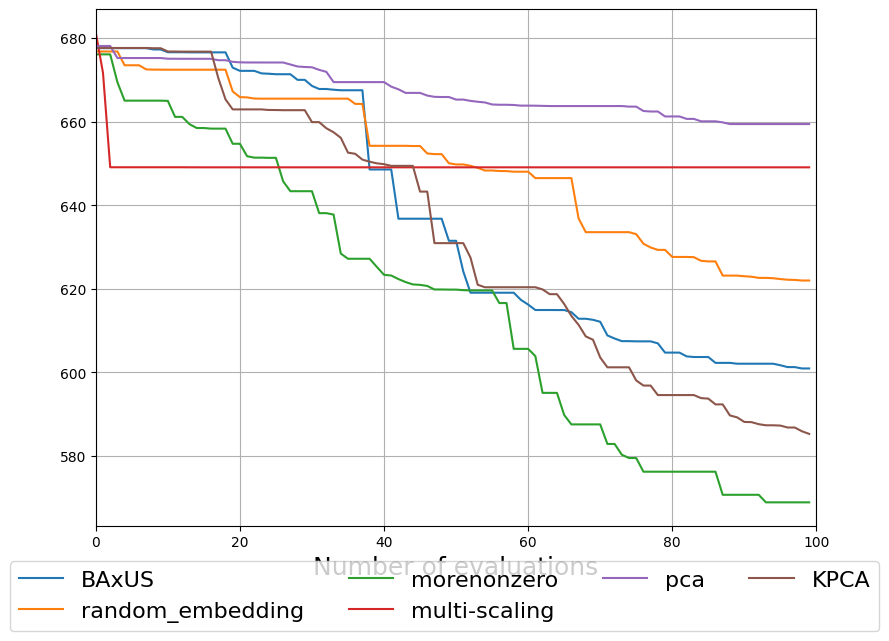

In [8]:
names = ["BAxUS", 'random_embedding', 'morenonzero', 'multi-scaling', 'pca', 'KPCA']
runs = [-Y_baxus_all[0], -Y_baxus_all[1], -Y_baxus_all[2], -Y_baxus_all[3], -Y_baxus_all[4], -Y_baxus_all[5]]

fig, ax = plt.subplots(figsize=(8, 6))
for name, run in zip(names, runs):
    fx =  np.minimum.accumulate(run.cpu())
    plt.plot(fx)
    # plt.plot(-fx + branin.optimal_value, marker="", lw=3)

plt.xlabel("Number of evaluations", fontsize=18)
plt.xlim([0, len(Y_baxus)])
# plt.yscale("log")

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()